# Clustering based on BYTES, PACKETS, DURATION

## Preparing a dataset

Load the dataset.

In [2]:
from cesnet_datazoo.datasets import CESNET_QUIC22, CESNET_TLS22

dataset = CESNET_QUIC22(data_root="data/CESNET_QUIC22/", size="XS", silent=True)

Prepare the dataset with config and see its columns.

In [3]:
from cesnet_datazoo.config import DatasetConfig

dataset_config = DatasetConfig(
    dataset=dataset,
    train_period_name="W-2022-44",
    train_size=50_000,
    use_packet_histograms=True,
)
dataset.set_dataset_config_and_initialize(dataset_config)

data_df = dataset.get_train_df()
data_df.columns

Index(['PPI', 'BYTES', 'BYTES_REV', 'PACKETS', 'PACKETS_REV', 'DURATION',
       'PPI_LEN', 'PPI_ROUNDTRIPS', 'PPI_DURATION', 'FLOW_ENDREASON_IDLE',
       'FLOW_ENDREASON_ACTIVE', 'FLOW_ENDREASON_OTHER', 'PSIZE_BIN1',
       'PSIZE_BIN2', 'PSIZE_BIN3', 'PSIZE_BIN4', 'PSIZE_BIN5', 'PSIZE_BIN6',
       'PSIZE_BIN7', 'PSIZE_BIN8', 'PSIZE_BIN1_REV', 'PSIZE_BIN2_REV',
       'PSIZE_BIN3_REV', 'PSIZE_BIN4_REV', 'PSIZE_BIN5_REV', 'PSIZE_BIN6_REV',
       'PSIZE_BIN7_REV', 'PSIZE_BIN8_REV', 'IPT_BIN1', 'IPT_BIN2', 'IPT_BIN3',
       'IPT_BIN4', 'IPT_BIN5', 'IPT_BIN6', 'IPT_BIN7', 'IPT_BIN8',
       'IPT_BIN1_REV', 'IPT_BIN2_REV', 'IPT_BIN3_REV', 'IPT_BIN4_REV',
       'IPT_BIN5_REV', 'IPT_BIN6_REV', 'IPT_BIN7_REV', 'IPT_BIN8_REV', 'APP'],
      dtype='object')

Get only the columns that are needed for clustering.

In [4]:
import numpy as np

features_to_extract =["PACKETS", "PACKETS_REV", "BYTES", "BYTES_REV", "DURATION", "PPI_LEN", "PPI_ROUNDTRIPS", "PPI_DURATION"]

features_array = data_df[features_to_extract].to_numpy()
app_array = data_df[["APP"]].to_numpy().reshape(-1)

## Analysis

Discover statistics of the dataset.

In [5]:
data_df[features_to_extract].describe()

,PACKETS,PACKETS_REV,BYTES,BYTES_REV,DURATION,PPI_LEN,PPI_ROUNDTRIPS,PPI_DURATION
count,50000.000000,50000.000000,5.000000e+04,5.000000e+04,50000.000000,50000.000000,50000.000000,50000.000000
mean,42.151119,149.952026,1.385958e+04,1.685731e+05,9.297396,23.132601,4.547780,3.228835
std,384.462280,2562.677246,1.838630e+05,3.248007e+06,28.892742,7.268107,1.866096,11.992882
min,1.000000,1.000000,1.228000e+03,7.500000e+01,0.000302,2.000000,0.000000,0.000000
25%,8.000000,9.000000,2.730000e+03,3.244000e+03,0.094288,17.000000,3.000000,0.078000
50%,12.000000,13.000000,4.177500e+03,5.259000e+03,0.216789,25.000000,4.000000,0.155000
75%,22.000000,24.000000,7.127250e+03,1.051250e+04,4.942341,30.000000,6.000000,0.585250
max,68950.000000,489305.000000,2.149850e+07,6.242670e+08,356.115967,30.000000,13.000000,268.566010


Head of the dataset.

In [6]:
data_df[[*features_to_extract, "APP"]].head()

,PACKETS,PACKETS_REV,BYTES,BYTES_REV,DURATION,PPI_LEN,PPI_ROUNDTRIPS,PPI_DURATION,APP
0,84.0,122.0,9732.0,86583.0,26.039257,30.0,1.0,0.024,100
1,30.0,29.0,16356.0,7428.0,38.799259,30.0,6.0,4.799,55
2,15.0,15.0,2931.0,3921.0,0.101522,30.0,6.0,0.102,55
3,193.0,1040.0,36355.0,1131255.0,38.705891,30.0,3.0,0.082,29
4,111.0,719.0,24827.0,862051.0,4.751750,30.0,4.0,0.100,29


## Categorization of original classes

Define the original clustering using dataset's categories.

In [7]:
categories_enum = {category: i for i, category in dataset._tables_cat_enum.items()}
app_to_categories = dataset.class_info.categories_mapping
app_enum = {i: app for i, app in dataset._tables_app_enum.items()}
app_to_categories.update({
    "bongacams": "Streaming media",
    "gothbb": "E-commerce",
    "vkontakte": "Social",
    "poe-ninja": "Games",
    "unpkg": "Streaming media",
    "easylist": "Other services and APIs",
    "default-background": "default",
    "uber": "Other services and APIs",
})

categories_array = np.array([categories_enum[app_to_categories[app_enum[app]]] for app in app_array])

Choose the correct clusters from the dataset: categories or apps.

## Preprocessing

Define a pipeline for preprocessing.

In [8]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

preprocessing_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=2)),
])

preprocessed_array = preprocessing_pipeline.fit_transform(features_array)

## Clustering

Define function for DBSCAN clustering.

In [9]:
from sklearn.cluster import DBSCAN, HDBSCAN

def dbscan_clustering(data, eps=0.1, min_samples=5):
    return DBSCAN(eps=eps, min_samples=min_samples).fit(data)

def hdbscan_clustering(data, min_cluster_size=5, min_samples=5):
    return HDBSCAN(min_cluster_size=min_cluster_size, min_samples=min_samples).fit(data)

Perform DBSCAN clustering.

In [10]:
model = dbscan_clustering(preprocessed_array, eps=0.05, min_samples=3)
labels = model.labels_[:]

Perform an analysis of different hyperparameters and plot them to line chart.

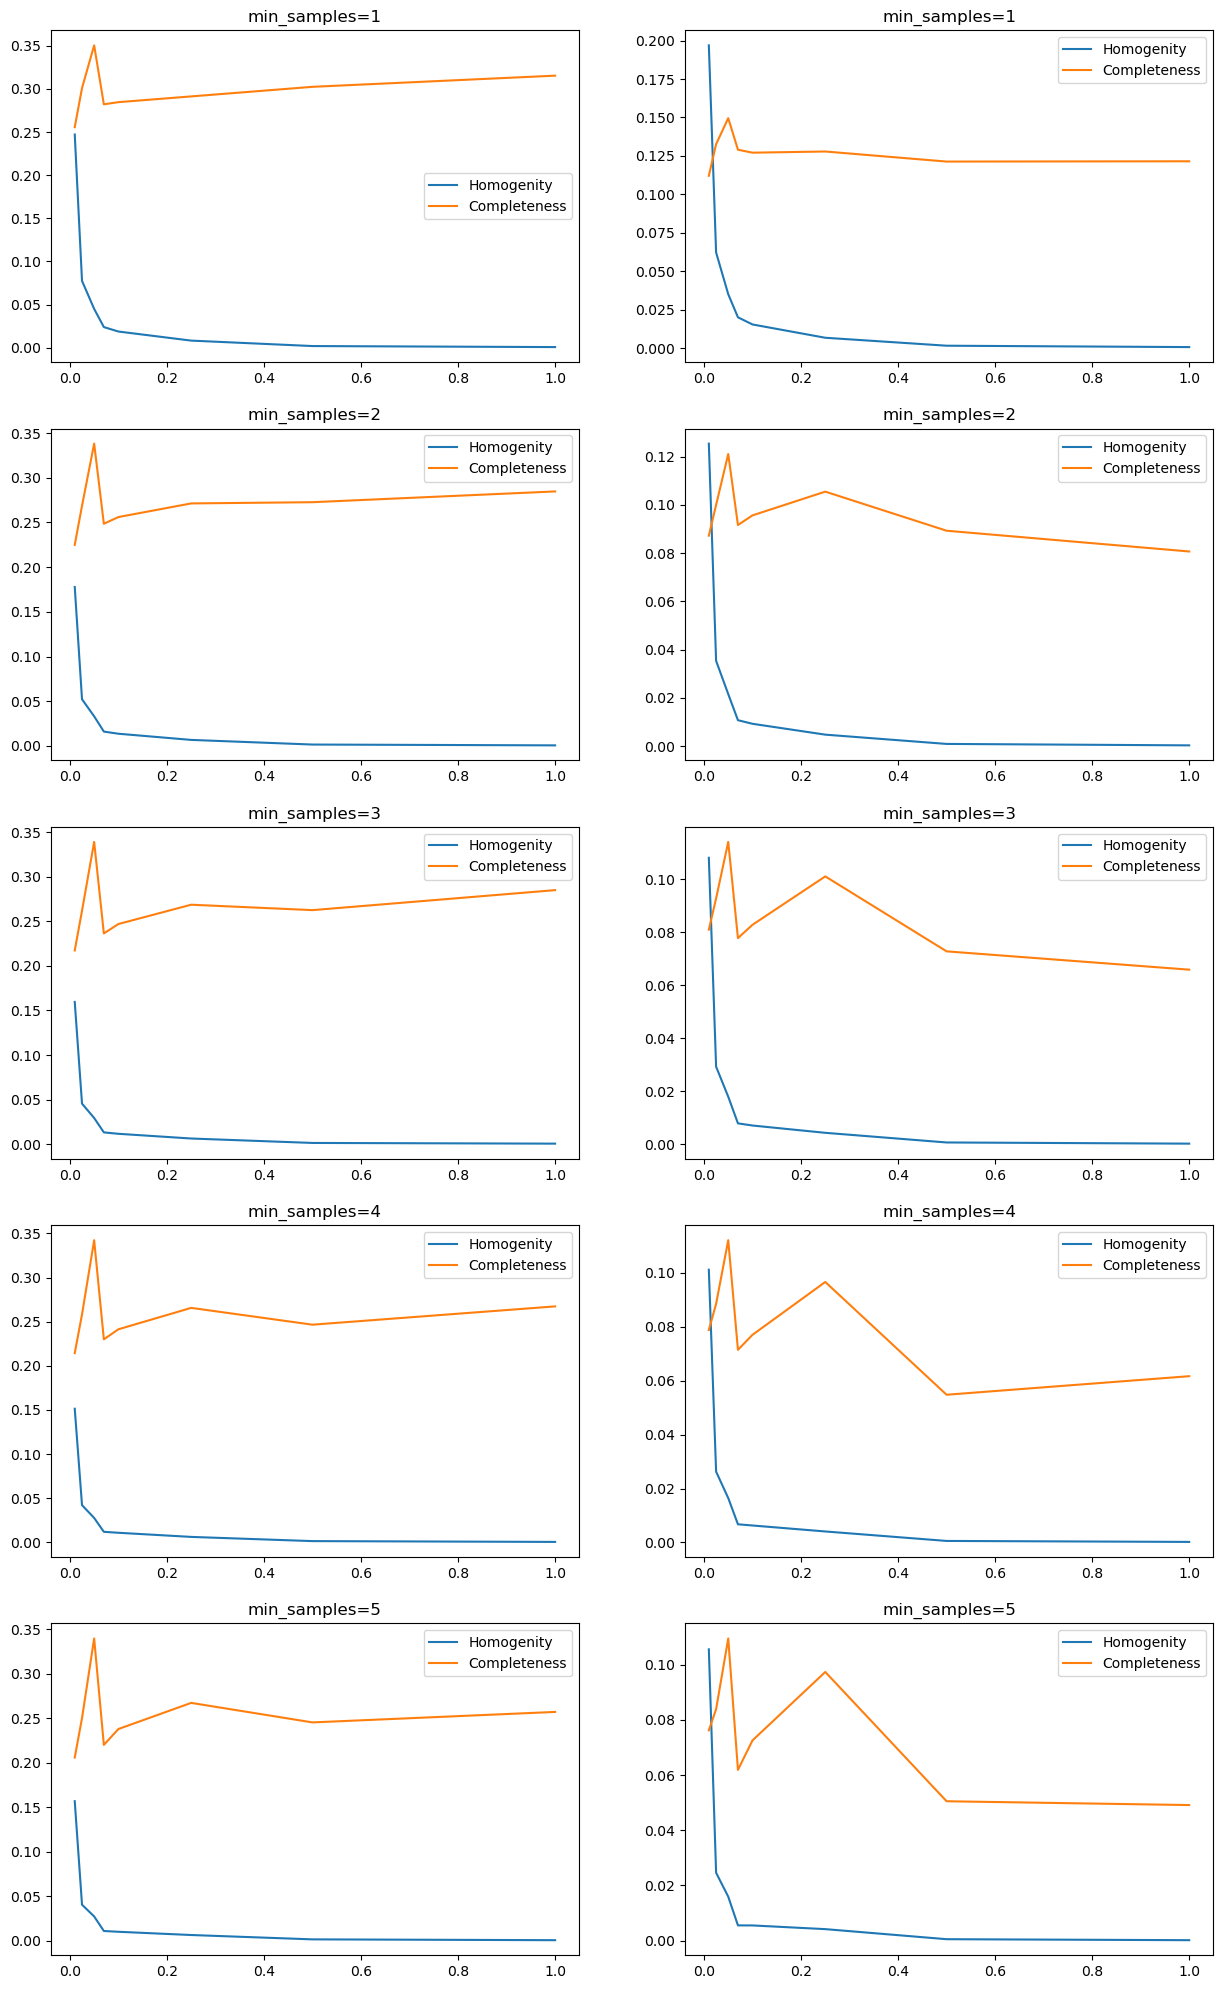

In [23]:
from matplotlib import pyplot as plt
from sklearn.metrics import homogeneity_completeness_v_measure

eps_values = [0.01, 0.025, 0.05, 0.07, 0.1, 0.25, 0.5, 1]

fig, ax = plt.subplots(5, 2, figsize=(15, 25))

for min_samples in range(1, 6):
    current_ax = ax[min_samples - 1]
    current_ax[0].set_title(f"min_samples={min_samples}")
    current_ax[1].set_title(f"min_samples={min_samples}")
    
    app_scores = []
    categories_scores = []
    
    for eps in eps_values:
        test_model = dbscan_clustering(preprocessed_array, eps=eps, min_samples=min_samples)
        test_labels = test_model.labels_[:]
        
        app_scores.append(homogeneity_completeness_v_measure(app_array, test_labels))
        categories_scores.append(homogeneity_completeness_v_measure(categories_array, test_labels))
        
    current_ax[0].plot(eps_values, [score[0] for score in app_scores], label="Homogenity")
    current_ax[0].plot(eps_values, [score[1] for score in app_scores], label="Completeness")
    
    current_ax[1].plot(eps_values, [score[0] for score in categories_scores], label="Homogenity")
    current_ax[1].plot(eps_values, [score[1] for score in categories_scores], label="Completeness")
    
    current_ax[0].legend()
    current_ax[1].legend()
        
plt.show()
        

## Postprocessing

Remove outliers.

In [12]:
import numpy as np

outliers = np.where(model.labels_ == -1)
# no_outliers_array = np.delete(preprocessed_array, outliers)
# no_outliers_clusters_app = np.delete(correct_clusters_array, outliers)
# no_outliers_labels = np.delete(model.labels_, outliers)

f"Number of outliers: {len(outliers[0])}"

'Number of outliers: 1108'

## Evaluation

### Homogeneity, completeness and V-measure

In [13]:
from sklearn.metrics import homogeneity_completeness_v_measure

homogeneity, completeness, v_measure = homogeneity_completeness_v_measure(categories_array, labels)
f"Homogeneity (each cluster contains only members of a single class): {homogeneity}", f"Completeness (all members of a given class are assigned to the same cluster): {completeness}", f"V-measure: {v_measure}"

('Homogeneity (each cluster contains only members of a single class): 0.01795776896421769',
 'Completeness (all members of a given class are assigned to the same cluster): 0.11416162181460841',
 'V-measure: 0.031033870456745796')

In [14]:
homogeneity, completeness, v_measure = homogeneity_completeness_v_measure(app_array, labels)
f"Homogeneity (each cluster contains only members of a single class): {homogeneity}", f"Completeness (all members of a given class are assigned to the same cluster): {completeness}", f"V-measure: {v_measure}"

('Homogeneity (each cluster contains only members of a single class): 0.029322258689319418',
 'Completeness (all members of a given class are assigned to the same cluster): 0.3388976953708119',
 'V-measure: 0.053974510524512936')

### Fowlkes-Mallows index

In [15]:
from sklearn.metrics import fowlkes_mallows_score

"FM score:", fowlkes_mallows_score(labels, categories_array)

('FM score:', 0.40461233223360155)

### Pair matrix

In [16]:
from sklearn.metrics import pair_confusion_matrix

matrix = pair_confusion_matrix(categories_array, labels)
f"In true labelling: together, but in predicted: not  {matrix[1, 0]}", f"In true labelling: not together, but in predicted: together  {matrix[0, 1]}", f"In true labelling: together, and in predicted: together  {matrix[1, 1]}", f"In true labelling: not together, and in predicted: not together  {matrix[0, 0]}"

('In true labelling: together, but in predicted: not  46167072',
 'In true labelling: not together, but in predicted: together  1854329932',
 'In true labelling: together, and in predicted: together  412651838',
 'In true labelling: not together, and in predicted: not together  186801158')

In [17]:
matrix = pair_confusion_matrix(app_array, labels)
f"In true labelling: together, but in predicted: not  {matrix[1, 0]}", f"In true labelling: not together, but in predicted: together  {matrix[0, 1]}", f"In true labelling: together, and in predicted: together  {matrix[1, 1]}", f"In true labelling: not together, and in predicted: not together  {matrix[0, 0]}"

('In true labelling: together, but in predicted: not  7162210',
 'In true labelling: not together, but in predicted: together  2178614440',
 'In true labelling: together, and in predicted: together  88367330',
 'In true labelling: not together, and in predicted: not together  225806020')

## Visualization

Define function for visualization.

In [18]:
import matplotlib.pyplot as plt

axis_zoom = [0, 6, -2, 4]

def plot_clusters(data, label, axis=True):
    plt.figure(figsize=(10, 10))
    plt.scatter(data[:, 0], data[:, 1], c=label)
    
    plt.axis(axis)
    
max(labels)


127

Visualize the clusters.

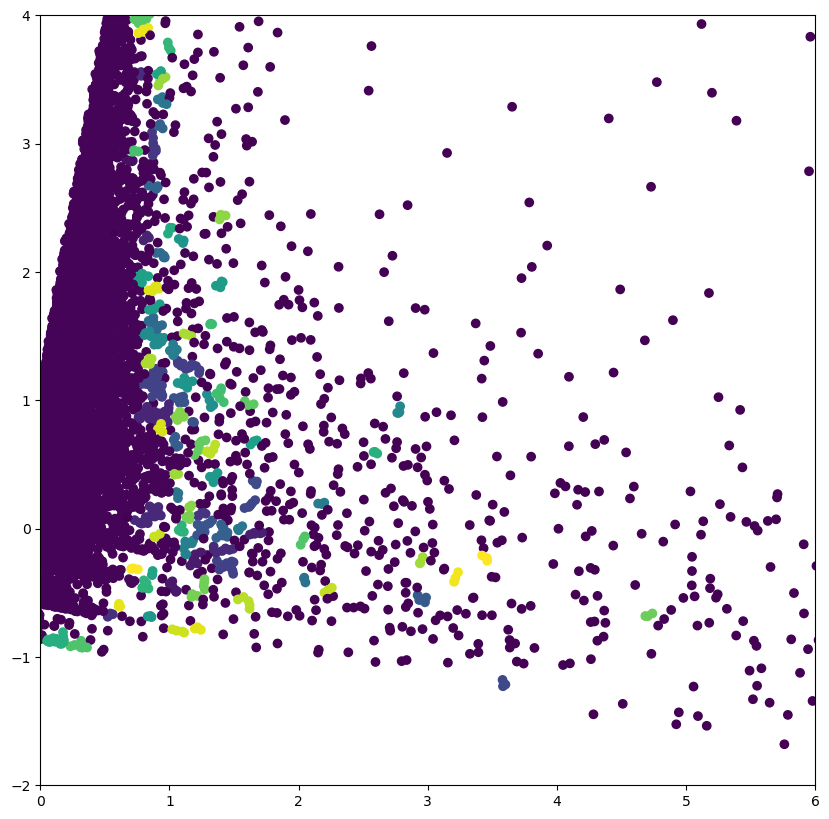

In [19]:
plot_clusters(preprocessed_array, labels, axis_zoom)
# plot_clusters(no_outliers_array, no_outliers_labels, [-0.1, 0.2, -0.1, 0.1])

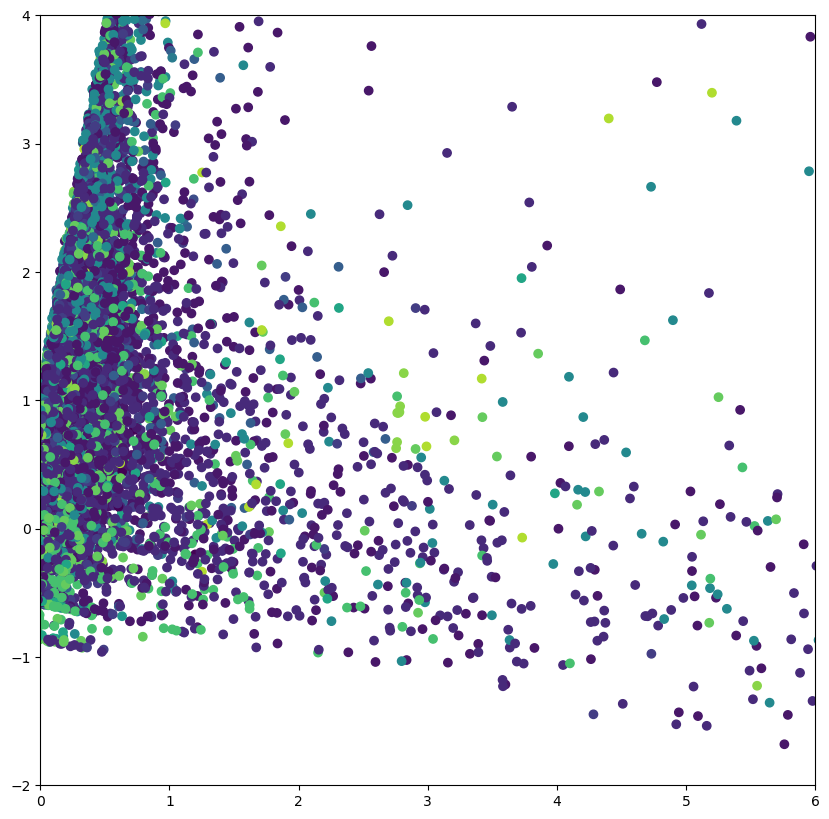

In [20]:
plot_clusters(preprocessed_array, categories_array, axis_zoom)

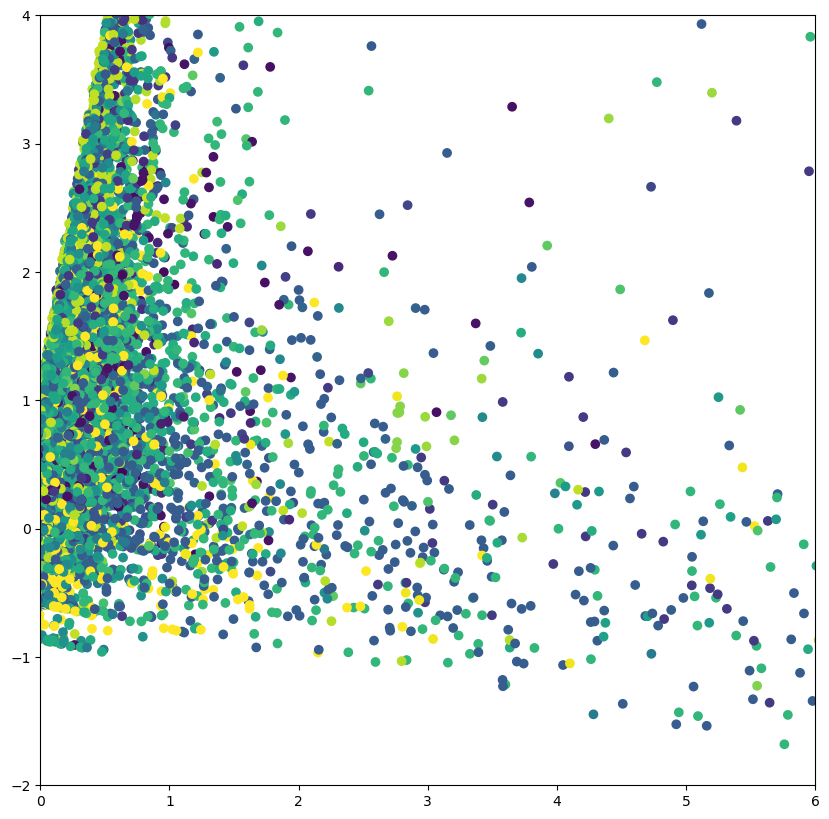

In [21]:
plot_clusters(preprocessed_array, app_array, axis_zoom)
# plot_clusters(no_outliers_array, no_outliers_clusters_app, [-0.1, 0.2, -0.1, 0.1])

AttributeError: 'DBSCAN' object has no attribute 'condensed_tree_'